# Part 1 - Data Visualisation of Workflow Outputs

In [7]:
pip install requests boto3 dotenv

Note: you may need to restart the kernel to use updated packages.


### Set required variables

In [11]:
import os
from dotenv import load_dotenv

load_dotenv("prod.env")

WORKSPACE_API_KEY = '' # navigate to https://eodatahub.org.uk/workspaces/ and go to the credentials tab of your chosen workspace
WORKSPACE_NAME = '' # the name/id of the workspace

## Let's Add the Data to your Object store and Block store

_We will put sample geospatial assets into your object/block store which is a prerequisite to a notebook detailing how to use TiTiler_

In [12]:
import os
import requests
import zipfile

import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

# Use any COG/GeoTIFF you like. Learn more about the differences between COG and GeoTIFF here:
# https://eodatahub.org.uk/docs/documentation/visualisation/preparing-data/
cog_url = 'https://github.com/GeoTIFF/test-data/raw/refs/heads/main/files/GA4886_VanderfordGlacier_2022_EGM2008_64m-epsg3031.cog'
response = requests.get(cog_url)

# Block Store (We'll add a sample COG and a sample ZARR)
os.makedirs('visualisation-block-store-samples', exist_ok=True)
with open('visualisation-block-store-samples/sample.cog', 'wb') as f:
    f.write(response.content)
with zipfile.ZipFile('example_zarr.zip', 'r') as zip_ref:
    zip_ref.extractall('visualisation-block-store-samples')

# Object Store (S3)
# You should already have these set in your env variables, if not navigate to https://eodatahub.org.uk/workspaces/ -> Credentials -> S3 Token
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID') 
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = boto3.client(
    's3',
    region_name='eu-west-2',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
) 


resp = s3.upload_file('visualisation-block-store-samples/sample.cog', 'workspaces-eodhp', f'{WORKSPACE_NAME}/visualisation-object-store-samples/sample.cog')

zarr_dir = 'visualisation-block-store-samples/days_tas_above_15c_ukcp18_rcp85_2030_xarray'
s3_prefix = f'{WORKSPACE_NAME}/visualisation-object-store-samples/days_tas_above_15c_ukcp18_rcp85_2030_xarray'

for root, dirs, files in os.walk(zarr_dir):
    for file in files:
        local_path = os.path.join(root, file)
        relative_path = os.path.relpath(local_path, zarr_dir)
        s3_path = f'{s3_prefix}/{relative_path}'
        s3.upload_file(local_path, 'workspaces-eodhp', s3_path)

# COG / GeoTIFF (Block Store and Object Store)

## Discover more about the data you published

In [13]:
import requests
import json


# Experiment with both of these. Follow the COG/GeoTIFF section of this notebook making use of both the object store and/or the block store url.
WORKSPACE_COG_URL = f'https://workspaces-eodhp.s3.eu-west-2.amazonaws.com/{WORKSPACE_NAME}/visualisation-object-store-samples/sample.cog' # Object store
WORKSPACE_COG_URL = f'/{WORKSPACE_NAME}/visualisation-block-store-samples/sample.cog' # Block store

# get info
TITILER_INFO_URL = f'https://eodatahub.org.uk/titiler/core/cog/info'
TITILER_INFO_PARAMS = {
    'url': WORKSPACE_COG_URL,
    'bidx': 1,
}

# Note the use of the Authorization header with your Workspace API key attached, this is how to visualise your private workspace data.
response = requests.get(TITILER_INFO_URL, params=TITILER_INFO_PARAMS, headers={'Authorization': f'Bearer {WORKSPACE_API_KEY}'})
print(json.dumps(response.json(), indent=4))

# get stats
TITILER_STATS_URL = f'https://eodatahub.org.uk/titiler/core/cog/statistics'
TITILER_STATS_PARAMS = {
    'url': WORKSPACE_COG_URL,
    'bidx': 1,
}
response = requests.get(TITILER_STATS_URL, params=TITILER_STATS_PARAMS, headers={'Authorization': f'Bearer {WORKSPACE_API_KEY}'})
print(json.dumps(response.json(), indent=4))


{
    "bounds": [
        2409289.215427182,
        -965456.6416782856,
        2577115.3174883286,
        -835539.3414387774
    ],
    "crs": "http://www.opengis.net/def/crs/EPSG/0/3031",
    "band_metadata": [
        [
            "b1",
            {
                "Band_Direction": "Height",
                "Band_Name": "Depth"
            }
        ]
    ],
    "band_descriptions": [
        [
            "b1",
            "Depth"
        ]
    ],
    "dtype": "float32",
    "nodata_type": "Nodata",
    "colorinterp": [
        "gray"
    ],
    "scales": [
        1.0
    ],
    "offsets": [
        0.0
    ],
    "driver": "GTiff",
    "count": 1,
    "width": 2581,
    "height": 1998,
    "overviews": [
        2,
        4,
        8
    ],
    "nodata_value": 3.4028234663852886e+38
}
{
    "b1": {
        "min": -2497.023681640625,
        "max": 1834.0904541015625,
        "mean": -845.5785773036869,
        "count": 62493.0,
        "sum": -52842742.031439304,
        "

### Previewing the Asset before serving it

Experiment with different rescales and colormap options to see what works best for your data.

Example colormaps: `'accent', 'accent_r', 'afmhot', 'afmhot_r', 'algae', 'algae_r', 'amp', 'amp_r', 'autumn', 'autumn_r', 'balance', 'balance_r', 'binary', 'binary_r', 'blues', 'blues_r', 'bone', 'bone_r', 'brbg', 'brbg_r', 'brg', 'brg_r', 'bugn', ...`

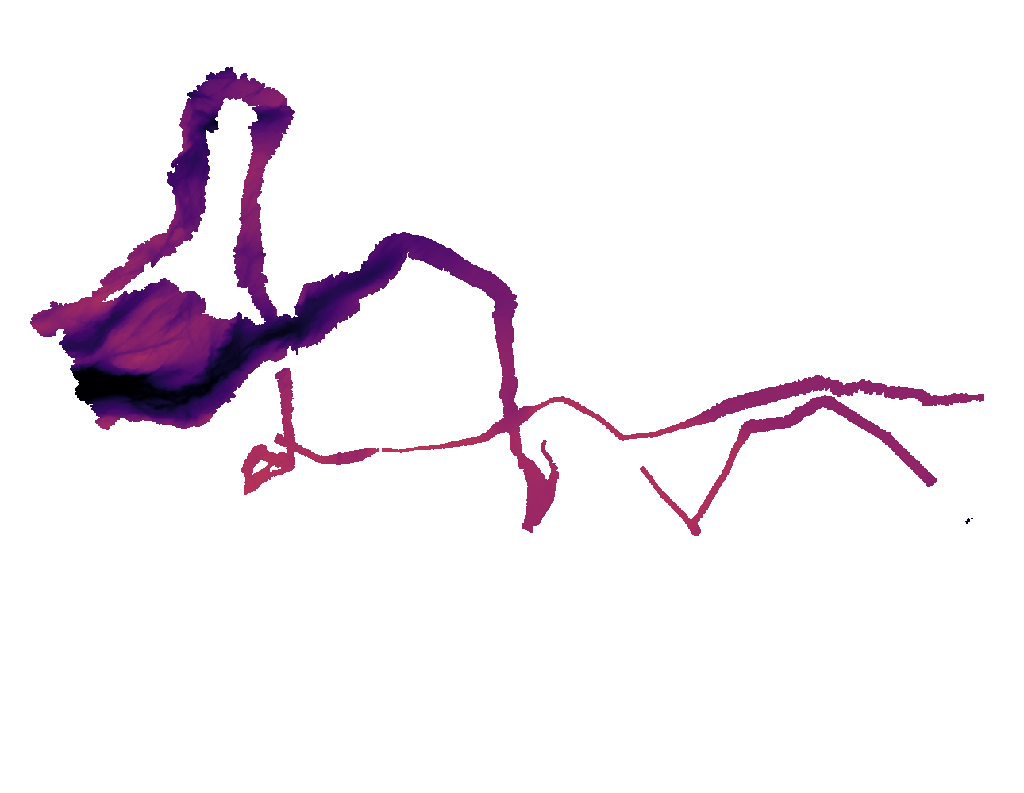

In [ ]:
from IPython.display import Image, display

TITILER_PREVIEW_URL = 'https://eodatahub.org.uk/titiler/core/cog/preview'

TITILER_PREVIEW_PARAMS = {
    'url': WORKSPACE_COG_URL,
    'bidx': 1, # this is the band index, in this case we have only one band "b1", so 1 -> b1.
    'rescale': '-2000,2000', # try with different comma seperated integers and see how it changes the visualisation,
    'colormap_name': 'inferno' # experiment with rainbow, bone, plasma... see the full lis above
}

response = requests.get(
    TITILER_PREVIEW_URL, 
    params=TITILER_PREVIEW_PARAMS, 
    headers={'Authorization': f'Bearer {WORKSPACE_API_KEY}'}
)

image = Image(response.content)
display(image)

## Visualise this in a 3rd Party Application (QGIS)

To visualise the data in a 3rd party application, we can use the Hub's OGC XYZ Tile Service.

This OGC service works both for public and private datasets. For private datasets, you will need to add an `Authorization` header to your requests.

This is an example public ESA CCI Land Cover dataset we can use as a basemap.

```
https://eodatahub.org.uk/titiler/core/cog/tiles/WebMercatorQuad/{z}/{x}/{y}?scale=1&url=https%3A%2F%2Fdap.ceda.ac.uk%2Fneodc%2Fesacci%2Fland_cover%2Fdata%2Fland_cover_maps%2Fv2.0.7%2FESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif&bidx=1&rescale=0%2C300&colormap_name=rainbow
```

XYZ Tile URL: https://eodatahub.org.uk/titiler/core/cog/tiles/WebMercatorQuad/{z}/{x}/{y}?url=https://james-hinton.eodatahub-workspaces.org.uk/files/workspaces-eodhp/public/visualisation-object-store-samples/sample.cog&bidx=1&rescale=-1000,1000&colormap_name=rainbow
This is an example XYZ tile request that attaches the Authorization header onto it


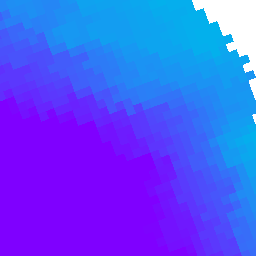

If you are using the XYZ Tile URL in a third-party app, and you used the example COG this is where you will find it:


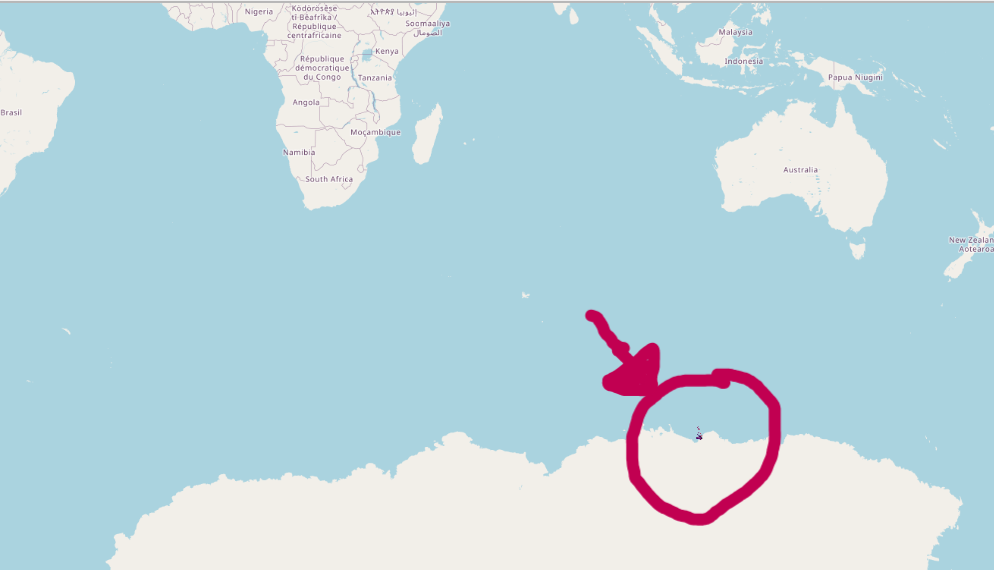

In [32]:
TITILER_TILES_URL = 'https://eodatahub.org.uk/titiler/core/cog/tiles/WebMercatorQuad/{z}/{x}/{y}'

xyz_tileurl = TITILER_TILES_URL + '?' + '&'.join([f'{k}={v}' for k, v in TITILER_PREVIEW_PARAMS.items()])
print(f"XYZ Tile URL: {xyz_tileurl}")
# it uses OGC XYZ Tiles service and the third party app will automatically replace the {z} {x} {y} with the tiles.
# This OGC XYZ Tiles URL works with third-party apps such as QGIS, ArcGIS as long as you attach the 'Authorization' header!

# An example request where we're manually setting the {z} {x} {y}
world_tile = xyz_tileurl.format(z=13, x=6606, y=6135) # This tile is near antartica.
response = requests.get(world_tile, headers={'Authorization': f'Bearer {WORKSPACE_API_KEY}'})

image = Image(response.content)
print('This is an example XYZ tile request that attaches the Authorization header onto it')
display(image)

print('If you are using the XYZ Tile URL in a third-party app, and you used the example COG this is where you will find it:')
display(Image(filename='./find_it.png'))

# XArray Files (ZARR)

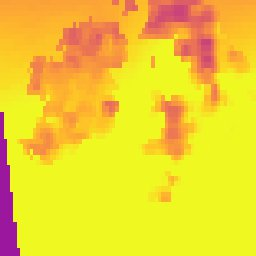

In [16]:
import requests
from IPython.display import Image, display

# The files we loaded earlier should be in your workspace. Experiment with both of these WORKSPACE_ZARR_URL as one is from your block store and other the object store.
WORKSPACE_ZARR_URL = f'{WORKSPACE_NAME}/visualisation-block-store-samples/days_tas_above_15c_ukcp18_rcp85_2030_xarray'
WORKSPACE_ZARR_URL = f'https://workspaces-eodhp.s3.eu-west-2.amazonaws.com/{WORKSPACE_NAME}/visualisation-object-store-samples/days_tas_above_15c_ukcp18_rcp85_2030_xarray' # Object stor


XARRAY_PREVIEW_URL = 'https://eodatahub.org.uk/titiler/xarray/tiles/5/15/10'
XARRAY_PARAMS = {
    'url': WORKSPACE_ZARR_URL,
    'variable': 'data',
    'rescale': '-50,100',
    'colormap_name': 'plasma',
    'reference' : 'true'
}

constructed_url = (
    f"{XARRAY_PREVIEW_URL}?"
    f"url={WORKSPACE_ZARR_URL}&"
    f"variable=rsus&"
    f"rescale=35,400&"
    f"colormap_name=plasma&"
    f"reference=true"
)

response = requests.get(
    XARRAY_PREVIEW_URL, 
    params=XARRAY_PARAMS, 
    headers={'Authorization': f'Bearer {WORKSPACE_API_KEY}'}
)

image = Image(response.content)
display(image)

In [17]:
# Again this will work with QGIS. Just make sure to include the Authorization header with your workspace API key as the Bearer token.

TITILER_XARRAY_TILES_URL = 'https://eodatahub.org.uk/titiler/xarray/tiles/WebMercatorQuad/{z}/{x}/{y}'
print(TITILER_XARRAY_TILES_URL + '?' + '&'.join([f'{k}={v}' for k, v in XARRAY_PARAMS.items()]))

https://eodatahub.org.uk/titiler/xarray/tiles/WebMercatorQuad/{z}/{x}/{y}?url=https://workspaces-eodhp.s3.eu-west-2.amazonaws.com/james-hinton/visualisation-object-store-samples/days_tas_above_15c_ukcp18_rcp85_2030_xarray&variable=data&rescale=-50,100&colormap_name=plasma&reference=true


# Part 2 - Publishing a Workspace File

We can publish workspace results by copying them to the public directory. This example does it for an S3 file, but it also applies to an EFS file.

In [25]:
import boto3
import requests

FILE_PATH = f'visualisation-object-store-samples/sample.cog'

# Confirm file is not published
resp = requests.head(
    f"https://{WORKSPACE_NAME}.eodatahub-workspaces.org.uk/files/workspaces-eodhp/{FILE_PATH}", 
    headers={"accept": "application/json"}
)
print(f"File is not publically accessible: status={resp.status_code}")

File is not publically accessible: status=401


### Publish the file by copying it to the `public` directory.

In [27]:
src = f"{WORKSPACE_NAME}/{FILE_PATH}"
dest = f"{WORKSPACE_NAME}/public/{FILE_PATH}"

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

s3 = boto3.client(
    's3',
    region_name='eu-west-2',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

s3.copy(
    {
        "Bucket": "workspaces-eodhp", 
        "Key": src
    }, 
    "workspaces-eodhp", 
    dest,
)

public_s3_url_path = f"https://{WORKSPACE_NAME}.eodatahub-workspaces.org.uk/files/workspaces-eodhp/public/{FILE_PATH}"


print(f"File published: {dest}")

File published: james-hinton/public/visualisation-object-store-samples/sample.cog


### Confirm that the file has been published

In [28]:
resp = requests.head(
    public_s3_url_path, 
    headers={"accept": "application/json"}
)

print(f"File is publically accessible: status={resp.status_code}")

File is publically accessible: status=200


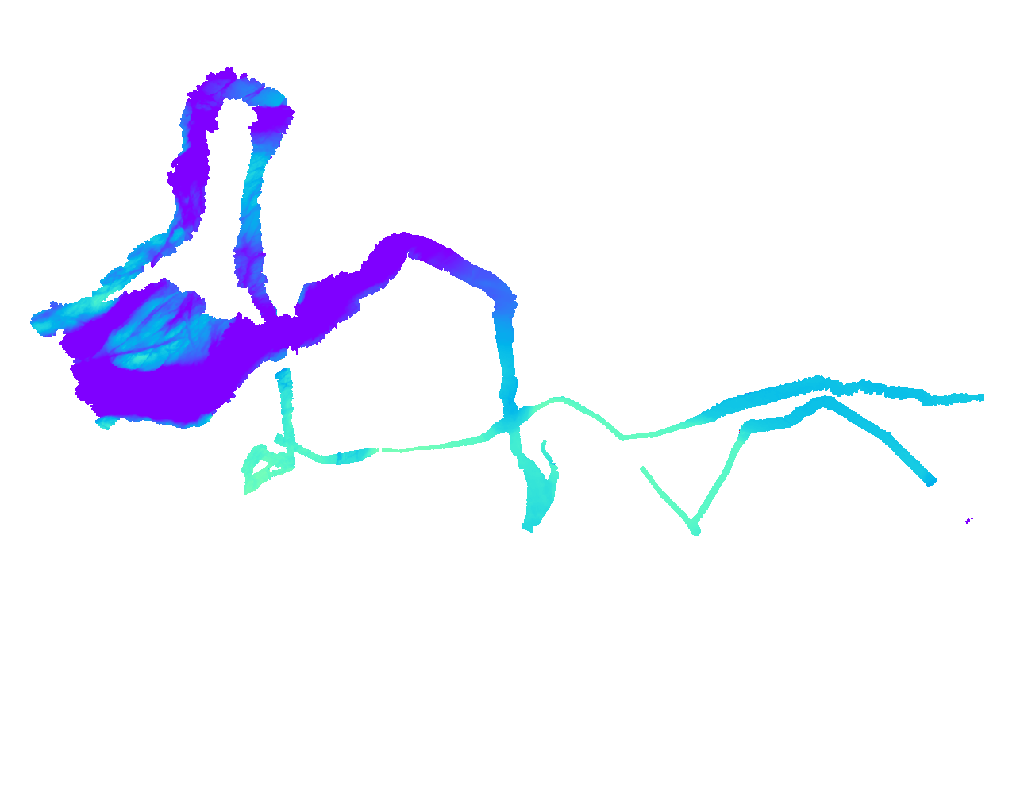

In [30]:
from IPython.display import Image, display

TITILER_PREVIEW_URL = 'https://eodatahub.org.uk/titiler/core/cog/preview'

TITILER_PREVIEW_PARAMS = {
    'url': public_s3_url_path,
    'bidx': 1,
    'rescale': '-1000,1000',
    'colormap_name': 'rainbow'
}

response = requests.get(
    TITILER_PREVIEW_URL, 
    params=TITILER_PREVIEW_PARAMS
)

image = Image(response.content)
display(image)